In [1]:
import torch
import torch.nn as nn
import numpy as np 
import random
import tqdm

In [2]:
H = torch.load("test/original_weights.pt")["H"].to("cpu").float()
weights = torch.load("test/original_weights.pt")["weights"].to("cpu").float()    

/home/lliu/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


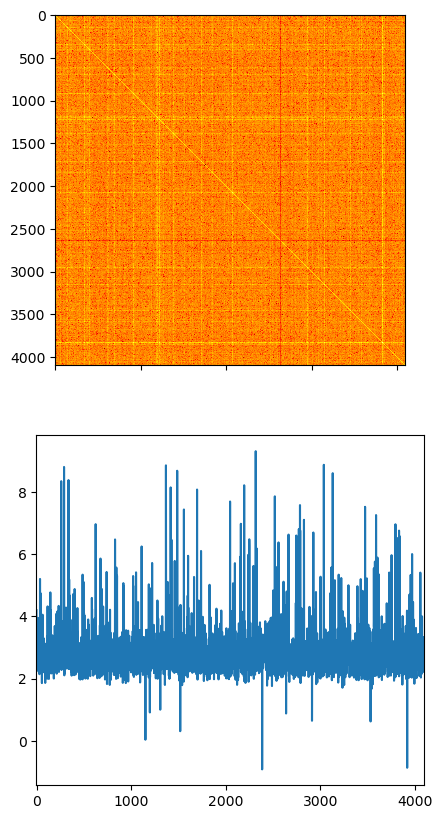

In [3]:
import matplotlib.pyplot as plt


#divide H by its diagonal
# H_ = H / torch.diag(H).unsqueeze(1)

H_ = torch.log(torch.abs(H))
# H_ = torch.clip(H_, -2, 2)

i1 = 10000
i2 = 1250


fig,axs = plt.subplots(2,1, figsize=(5,10),sharex=True)
plt.sca(axs[0])
cbar = plt.imshow(H_ .numpy(), cmap="hot", interpolation="nearest")

norms = torch.norm(H,dim = 0).numpy()
plt.sca(axs[1])
plt.plot(np.log(norms))

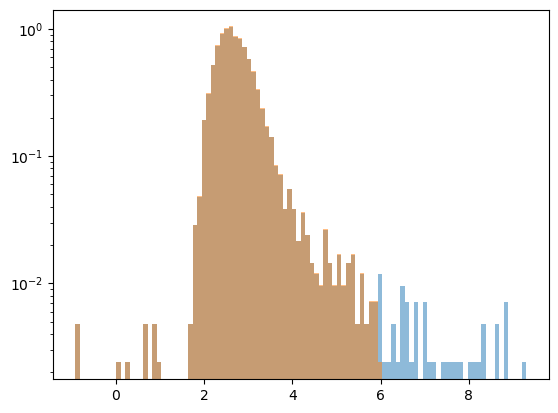

In [4]:
bins = plt.hist(np.log(norms), bins=100, density=True, alpha=0.5)[1]


top_n = 0.01
threshold = np.quantile(norms, 1-top_n)
mask = norms<threshold

plt.hist(np.log(norms[norms<threshold]), bins=bins, density=True, alpha=0.5)
plt.yscale("log")



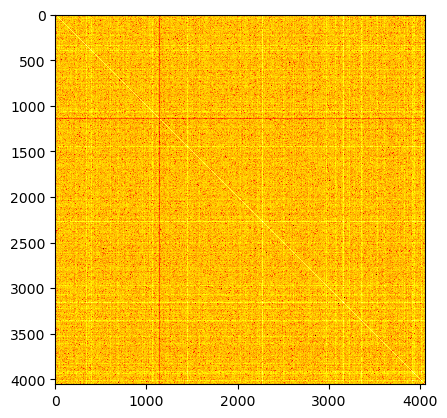

In [5]:
plt.imshow(H_ .numpy()[mask,:][:,mask], cmap="hot", interpolation="nearest")

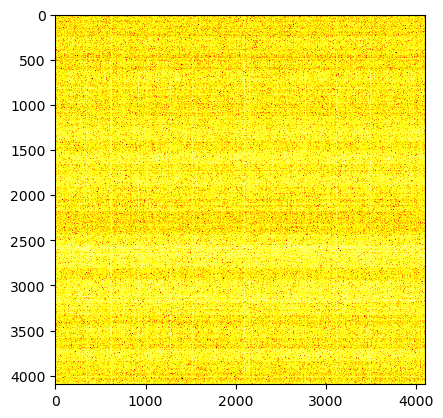

In [6]:
plt.imshow(torch.log(torch.abs(weights)).numpy(), cmap="hot", interpolation="nearest")

In [7]:
H_diag = torch.diag(H)
H_diag


tensor([7.1563, 2.0979, 1.1984,  ..., 2.6129, 1.7452, 2.0673])

In [8]:
import sklearn.cluster as cluster

In [9]:
def cluster_e_step(X,centriods,
                   weights):
    
    """
    X: torch tensor of the weights, rearanged into a shape of (n, d)
    centriods: torch.tensor of the centriods, shape of (k, d)
    weights: torch.tensor of shape (n,d)
    """

    # k = centriods.shape[0]

    errors = (X.unsqueeze(-1) - centriods.T.unsqueeze(0))**2
    #shape of (n, d, k)

    #multiply by the diagonal
    errors = errors * weights.unsqueeze(-1)

    #sum by the d
    errors = errors.sum(1)
    # print("errors[0,10,:] = ", errors[0,10,:])
    #shape of (n, k)
    # print(errors[0,10,:])
    assignments = errors.argmin(-1)
    # print("assignments[0,10] = ", assignments[0,10])
    # print("="*10)
    #shape of (n)
    return assignments


def cluster_m_step(X, assignments, k, weights):
    """
    X: torch tensor of the weights, rearanged into a shape of (n, d)
    assignments: torch.tensor of the assignments, shape of (n)
    k: int, number of clusters
    weights: torch.tensor of shape (n, d)
    """
    n, d = weights.shape

    #compute the new centriods
    centriods = torch.zeros((k,d), dtype = weights.dtype, device = weights.device)
    #shape of (k,d)
    for i in range(k):
        assignment_X = X[assignments == i] #shape of (n_i,d)
        assignments_weights = weights[assignments == i] #shape of (n_i,d)

        centriods[i] = torch.sum(assignments_weights * assignment_X, dim = 0) / torch.sum(assignments_weights, dim = 0)

    return centriods


def our_cluster(X, k, weights, n_iter = 100,
            centriods = None):
    """
    weights: torch tensor of the weights, rearanged into a shape of (n, d)
    k: int, number of clusters
    weights: torch.tensor of shape (n, d)
    n_iter: int, number of iterations
    """
    n, d = weights.shape

    #randomly select k centriods
    if centriods is None:
        n_1 = torch.from_numpy(np.random.choice(n, k, replace = False))
        centriods = X[n_1, :]
        # print(centriods)
    #shape of (k, d)
    for i in tqdm.tqdm(range(n_iter)):
        # print("X.shape = ", X.shape, "centriods.shape = ", centriods.shape, "weights.shape = ", weights.shape)
        assignments = cluster_e_step(X, centriods, weights)
        # print(assignments)
        # print(assignments.shape)
        centriods = cluster_m_step(X, assignments, k, weights)
        if i > 0:
            if torch.all(assignments == assignments_old):
                print("breaking at iteration", i)
                break
            # print("n_change:", torch.sum(assignments != assignments_old))
        assignments_old = assignments.clone()
    return assignments, centriods
    

def reconstruct_cluster(assignments, centriods):
    """
    assignments: torch.tensor of the assignments, shape of (n, m/d)
    centriods: torch.tensor of the centriods, shape of (k, d)
    H_diag: torch.tensor of shape (m/d,d)
    """
    reconstructed_X = centriods[assignments,:]
    #shape of (n, m/d, d)
    return reconstructed_X


In [10]:
def bin_entropy(values, bins:int = 100,eps = 1e-5):
    """
    values: torch.tensor of the values
    bins: int, number of bins
    """
    hist = torch.histc(values, bins = bins)
    hist = hist + eps
    hist = hist / hist.sum()
    # print(hist)
    # print(torch.log2(hist))
    entropy = - (hist * torch.log2(hist)).sum()
    return entropy

In [33]:
torch.random.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
import tqdm
import sklearn.cluster

n_iters = 25

d = 8
k_magnitude_codebook = 32
k_coseine_codebook = 128

print("average bits:", (np.log2(k_magnitude_codebook) + np.log2(k_coseine_codebook))/d)
keep_top = 0.01

row_assignments = torch.arange(weights.shape[1]).reshape(-1, d)
# row_assignments = torch.randperm(weights.shape[1]).reshape(-1, d)



weights_reshaped = weights[:,row_assignments] 
#shape of (n, m/d, d)

# H_diag = torch.diag(H)[row_assignments].unsqueeze(0).expand(weights_reshaped.shape[0], -1, -1)
H_diag = torch.ones_like(weights_reshaped)
#shape of (n, m/d, d)

weights_norms = torch.norm(weights_reshaped, dim = -1)

mask = weights_norms < torch.quantile(weights_norms, 1-keep_top)

print(torch.quantile(weights_norms, 1-keep_top), torch.max(weights_norms), torch.min(weights_norms))
print(torch.sum(mask)/(mask.shape[0]*mask.shape[1]), 1 - torch.sum(mask)/(mask.shape[0]*mask.shape[1]))
# raise ValueError
#mask of the top 1% of the weights

weights_norms_masked = weights_norms[mask]
weights_use = weights_reshaped[mask,:]/weights_norms_masked.unsqueeze(-1)
H_diag_use = H_diag[mask,:] #* weights_norms_masked.unsqueeze(-1)**2
# H_diag_use = torch.clip(H_diag_use, 0,100)

print("weights_norms_masked.shape", weights_norms_masked.shape)
print("weights_masked.shape = ", weights_use.shape)
print("H_diag_use.shape = ", H_diag_use.shape)


#first we get the magnitude codebook
magnitude_cluster = sklearn.cluster.k_means(torch.log(weights_norms_masked).cpu().numpy().reshape(-1,1), k_magnitude_codebook, n_init = 10)
magnitude_codebook, magnitude_assignments = magnitude_cluster[0], magnitude_cluster[1]

#try binning the magnitudes
# magnitude_codebook = np.linspace(np.log(weights_norms_masked.min()), np.log(weights_norms_masked.max()), k_magnitude_codebook).reshape(-1,1)
# magnitude_assignments = np.argmin(np.abs(np.log(weights_norms_masked.numpy()).reshape(-1,1) - magnitude_codebook.T), axis = 1)
print("magnitude_codebook = ", magnitude_codebook)
print("magnitude_assignments = ", magnitude_assignments)



assignments, centriods = our_cluster(weights_use, k_coseine_codebook, H_diag_use, n_iter = n_iters)


weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]
weights_reconstructued_flat[mask,:] = centriods[assignments,:] * torch.from_numpy(np.exp(magnitude_codebook[:,0][magnitude_assignments])).reshape(-1,1).float()


weights_reconstructued = torch.empty_like(weights)

weights_reconstructued[:,row_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)


diff = weights - weights_reconstructued

average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

print(f"average error {average_error}, H error {H_error}")


average bits: 1.5
tensor(0.2409) tensor(0.7983) tensor(0.0036)
tensor(0.9900) tensor(0.0100)
weights_norms_masked.shape torch.Size([2076180])
weights_masked.shape =  torch.Size([2076180, 8])
H_diag_use.shape =  torch.Size([2076180, 8])


magnitude_codebook =  [[-3.0968187]
 [-2.356486 ]
 [-3.5293107]
 [-1.7766634]
 [-2.9335842]
 [-4.140418 ]
 [-2.6473503]
 [-2.05652  ]
 [-3.7389417]
 [-3.2647233]
 [-2.8577497]
 [-2.505268 ]
 [-1.509303 ]
 [-2.2064247]
 [-4.629519 ]
 [-3.3492198]
 [-1.9746506]
 [-2.7860463]
 [-1.6522597]
 [-3.0135474]
 [-3.8583164]
 [-3.6295223]
 [-3.1808631]
 [-2.43149  ]
 [-4.335028 ]
 [-2.2811756]
 [-1.8829863]
 [-2.5771832]
 [-2.71653  ]
 [-3.9896917]
 [-3.4365554]
 [-2.1326845]]
magnitude_assignments =  [ 0  8 17 ... 10  6 27]


100%|██████████| 25/25 [02:21<00:00,  5.66s/it]


average error 0.5594131350517273, H error 78.04903411865234


In [57]:
torch.random.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
import tqdm
import sklearn.cluster

n_iters = 100

d = 8
k_magnitude_codebook = 32
k_coseine_codebook = 32
keep_top = 0.01

# print("average bits:", (np.log2(k_magnitude_codebook) + np.log2(k_coseine_codebook))/d)

overhead = k_magnitude_codebook * 16 + k_coseine_codebook * k_magnitude_codebook * 16
sparse_bits = 16* weights.shape[0] * weights.shape[1] * keep_top
encoding_bits = (np.ceil(np.log2(k_magnitude_codebook)) + np.ceil(np.log2(k_coseine_codebook)))/d * weights.shape[0] * weights.shape[1]
print("overhead = ", overhead/(weights.shape[0]*weights.shape[1]), "encoding_bits = ", encoding_bits/(weights.shape[0]*weights.shape[1]), "sparse_bits = ", sparse_bits/(weights.shape[0]*weights.shape[1]))
print("average_bits = ", (encoding_bits+ sparse_bits + overhead)/(weights.shape[0]*weights.shape[1]))
# raise ValueError

row_assignments = torch.arange(weights.shape[1]).reshape(-1, d)
# row_assignments = torch.randperm(weights.shape[1]).reshape(-1, d)



weights_reshaped = weights[:,row_assignments] 
#shape of (n, m/d, d)

H_diag = torch.diag(H)[row_assignments].unsqueeze(0).expand(weights_reshaped.shape[0], -1, -1)
# H_diag = torch.ones_like(weights_reshaped)
#shape of (n, m/d, d)

weights_norms = torch.norm(weights_reshaped, dim = -1)
# print(H[:,row_assignments].shape)
H_norms = torch.norm(H[:,row_assignments], dim = (0,-1))
mask_H = H_norms < torch.quantile(H_norms, 1-keep_top/2)
mask_H = mask_H.unsqueeze(0).expand(weights.shape[0], -1)


mask_norm = weights_norms < torch.quantile(weights_norms, 1-keep_top/2)

mask = mask_norm & mask_H

# raise ValueError
print(torch.quantile(weights_norms, 1-keep_top), torch.max(weights_norms), torch.min(weights_norms))
print(torch.sum(mask)/(mask.shape[0]*mask.shape[1]), 1 - torch.sum(mask)/(mask.shape[0]*mask.shape[1]))
# raise ValueError
#mask of the top 1% of the weights

weights_norms_masked = weights_norms[mask]
weights_use = weights_reshaped[mask,:]/weights_norms_masked.unsqueeze(-1)
H_diag_use = H_diag[mask,:] * weights_norms_masked.unsqueeze(-1)**2
# H_diag_use = torch.clip(H_diag_use, 0,100)

print("weights_norms_masked.shape", weights_norms_masked.shape)
print("weights_masked.shape = ", weights_use.shape)
print("H_diag_use.shape = ", H_diag_use.shape)


#first we get the magnitude codebook
magnitude_cluster = sklearn.cluster.k_means(torch.log(weights_norms_masked).cpu().numpy().reshape(-1,1), k_magnitude_codebook, n_init = 10)
magnitude_codebook, magnitude_assignments = magnitude_cluster[0], magnitude_cluster[1]

#try binning the magnitudes
# magnitude_codebook = np.linspace(np.log(weights_norms_masked.min()), np.log(weights_norms_masked.max()), k_magnitude_codebook).reshape(-1,1)
# magnitude_assignments = np.argmin(np.abs(np.log(weights_norms_masked.numpy()).reshape(-1,1) - magnitude_codebook.T), axis = 1)
print("magnitude_codebook = ", magnitude_codebook)
print("magnitude_assignments = ", magnitude_assignments)


codebooks = {}
assignments_dict = {}
for i in range(k_magnitude_codebook):
    mask_i = magnitude_assignments == i

    assignments, centriods = our_cluster(weights_use[mask_i,:], k_coseine_codebook, H_diag_use[mask_i,:], n_iter = n_iters)
    codebooks[i] = centriods
    assignments_dict[i] = assignments


weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]

for i in range(k_magnitude_codebook):
    mask_i = torch.from_numpy(magnitude_assignments == i)
    mask_ = torch.zeros_like(mask)
    mask_[mask] = mask_i
    weights_reconstructued_flat[mask_,:] = codebooks[i][assignments_dict[i],:] * np.exp(magnitude_codebook[i,0])
# weights_reconstructued_flat[mask,:] = centriods[assignments,:] * torch.from_numpy(np.exp(magnitude_codebook[:,0][magnitude_assignments])).reshape(-1,1).float()


weights_reconstructued = torch.empty_like(weights)

weights_reconstructued[:,row_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)


diff = weights - weights_reconstructued

average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

print(f"average error {average_error}, H error {H_error}")

overhead =  0.001007080078125 encoding_bits =  1.25 sparse_bits =  0.16
average_bits =  1.411007080078125


tensor(0.2409) tensor(0.7983) tensor(0.0036)
tensor(0.9895) tensor(0.0105)
weights_norms_masked.shape torch.Size([2075220])
weights_masked.shape =  torch.Size([2075220, 8])
H_diag_use.shape =  torch.Size([2075220, 8])
magnitude_codebook =  [[-3.18961  ]
 [-2.2575185]
 [-3.7530937]
 [-2.7287912]
 [-2.0001547]
 [-1.5659739]
 [-3.451292 ]
 [-4.1346006]
 [-2.8841379]
 [-2.494076 ]
 [-3.0364408]
 [-1.8061981]
 [-3.9899845]
 [-2.0901418]
 [-3.3588567]
 [-3.6479578]
 [-2.4153714]
 [-2.5728226]
 [-1.4087348]
 [-4.616752 ]
 [-2.806639 ]
 [-2.9608004]
 [-2.175726 ]
 [-3.8656266]
 [-3.271529 ]
 [-3.5477986]
 [-2.651019 ]
 [-2.3366718]
 [-1.6945843]
 [-4.3243847]
 [-1.9064724]
 [-3.1120808]]
magnitude_assignments =  [10  2 20 ... 20 26 17]


 91%|█████████ | 91/100 [00:03<00:00, 26.36it/s]


breaking at iteration 91


 52%|█████▏    | 52/100 [00:00<00:00, 99.06it/s] 


breaking at iteration 52


 93%|█████████▎| 93/100 [00:00<00:00, 137.84it/s]


breaking at iteration 93


 54%|█████▍    | 54/100 [00:01<00:01, 30.11it/s]


breaking at iteration 54


 67%|██████▋   | 67/100 [00:03<00:01, 16.81it/s]


breaking at iteration 67


 51%|█████     | 51/100 [00:00<00:00, 123.88it/s]


breaking at iteration 51


 34%|███▍      | 34/100 [00:00<00:00, 319.19it/s]


breaking at iteration 34


 91%|█████████ | 91/100 [00:07<00:00, 12.10it/s]


breaking at iteration 91


 96%|█████████▌| 96/100 [00:06<00:00, 15.22it/s]


breaking at iteration 96


 72%|███████▏  | 72/100 [00:06<00:02, 11.88it/s]


breaking at iteration 72


 69%|██████▉   | 69/100 [00:05<00:02, 13.55it/s]


breaking at iteration 69


 47%|████▋     | 47/100 [00:01<00:01, 38.06it/s]


breaking at iteration 47


 95%|█████████▌| 95/100 [00:00<00:00, 249.23it/s]


breaking at iteration 95


 62%|██████▏   | 62/100 [00:02<00:01, 22.30it/s]


breaking at iteration 62


100%|██████████| 100/100 [00:07<00:00, 13.16it/s]


average error 0.7488016486167908, H error 17.44101333618164


In [94]:

codebooks_use = {}
for i in range(k_magnitude_codebook):
    codebooks_use[i] = codebooks[i].clone().requires_grad_(True)


n_iters = 100
lr = 1
clamp_gradients = 1e-1
prev_loss = 1e10

for i in range(n_iters):
    weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

    weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]
    # print(codebooks_use[0])
    for i in range(k_magnitude_codebook):
        mask_i = torch.from_numpy(magnitude_assignments == i)
        assert torch.any(mask_i)
        mask_ = torch.zeros_like(mask)
        mask_[mask] = mask_i
        weights_reconstructued_flat[mask_,:] = torch.clip(codebooks_use[i][assignments_dict[i],:],-1,1) * np.exp(magnitude_codebook[i,0])
    # weights_reconstructued_flat[mask,:] = centriods[assignments,:] * torch.from_numpy(np.exp(magnitude_codebook[:,0][magnitude_assignments])).reshape(-1,1).float()


    weights_reconstructued = torch.empty_like(weights)

    weights_reconstructued[:,row_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)
    # print(weights_reconstructued)

    diff = weights - weights_reconstructued
    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)
    print(f"average error {average_error}, H error {H_error}")
    H_error.backward()

    if H_error > prev_loss:
        lr = lr/2
        print("reducing lr to ", lr)
    prev_loss = H_error.item()
    with torch.no_grad():
        for i in range(k_magnitude_codebook):
            # print(codebooks_use[i].grad)
            codebooks_use[i] -= torch.clip(lr * codebooks_use[i].grad, -clamp_gradients, clamp_gradients)
            # codebooks_use[i] = codebooks_use[i].clamp(-1,1)
        # raise ValueError
        for i in range(k_magnitude_codebook):
            codebooks_use[i].grad = None



average error 0.7488016486167908, H error 17.44101333618164
average error 0.7774922251701355, H error 15.31190013885498
average error 0.7675669193267822, H error 14.079553604125977
average error 0.7812708020210266, H error 13.760059356689453
average error 0.7763053774833679, H error 13.613879203796387
average error 0.7879971861839294, H error 13.536300659179688
average error 0.781194269657135, H error 13.433792114257812
average error 0.7925074100494385, H error 13.393668174743652
average error 0.7851340174674988, H error 13.310564041137695
average error 0.7961133718490601, H error 13.294461250305176
average error 0.7884359955787659, H error 13.223784446716309
average error 0.7991640567779541, H error 13.221076011657715
average error 0.7912752628326416, H error 13.15999698638916
average error 0.8018020987510681, H error 13.165607452392578
reducing lr to  0.5
average error 0.7971931099891663, H error 12.80738639831543
average error 0.7984045743942261, H error 12.777298927307129
average e

In [92]:
bits = 3
scale = (torch.min(weights) - torch.max(weights))/2**bits
bias = torch.min(weights)

weights_quantized = torch.round((weights - bias)/scale) * scale + bias

diff = weights - weights_quantized
average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)
print(f"average error {average_error}, H error {H_error}")

average error 1.404494285583496, H error 234.82614135742188


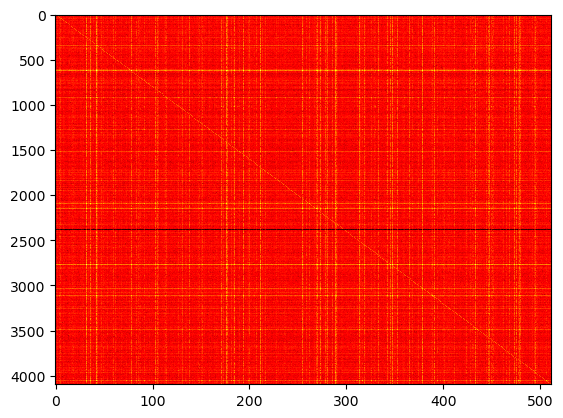

In [24]:
plt.imshow(torch.log(torch.norm(H[:,row_assignments], dim = -1)).numpy(), cmap="hot", interpolation="nearest", aspect="auto")

(array([1.07230467e-05, 3.57434891e-06, 6.43385079e-05, 1.28676561e-04,
        2.07312237e-04, 6.93423688e-04, 1.64062615e-03, 4.27492129e-03,
        9.23257588e-03, 1.86366552e-02, 3.56791508e-02, 6.62434083e-02,
        1.11001602e-01, 1.75936602e-01, 2.56230776e-01, 3.43813655e-01,
        4.27467109e-01, 5.02056622e-01, 5.54539768e-01, 5.95468656e-01,
        6.16286754e-01, 6.14484193e-01, 5.97016349e-01, 5.61148750e-01,
        5.03346962e-01, 4.32310352e-01, 3.39920882e-01, 2.49114467e-01,
        1.70600250e-01, 1.14425733e-01, 7.30739891e-02, 4.25061948e-02]),
 array([-5.61789513, -5.48307991, -5.34826469, -5.21344995, -5.07863474,
        -4.94381952, -4.80900431, -4.67418909, -4.53937387, -4.40455914,
        -4.26974392, -4.1349287 , -4.00011349, -3.86529851, -3.73048329,
        -3.59566808, -3.4608531 , -3.32603788, -3.19122267, -3.05640769,
        -2.92159247, -2.7867775 , -2.65196228, -2.51714706, -2.38233209,
        -2.24751687, -2.11270165, -1.97788656, -1.8430714

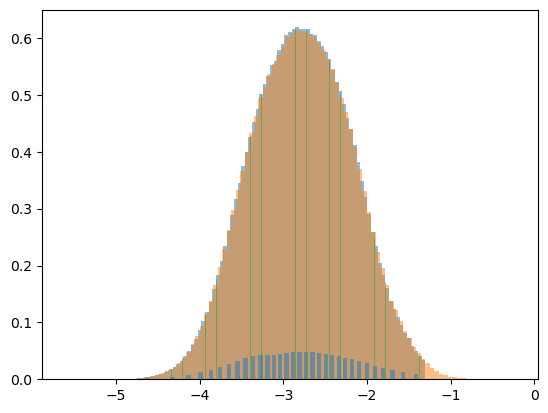

In [59]:
plt.hist(torch.log(weights_norms_masked).cpu().numpy(), bins = 100, alpha = 0.5, label = "weights",density=True)
plt.hist(torch.log(weights_norms).flatten().cpu().numpy(), bins = 100, alpha = 0.5, label = "weights_all",density=True)
plt.bar(magnitude_codebook[:,0], np.bincount(magnitude_assignments)/magnitude_assignments.shape[0], alpha = 0.5, label = "magnitude_codebook", width = 0.05, align='center')
plt.hist(torch.log(weights_norms_masked).flatten().cpu().numpy(), bins = k_magnitude_codebook, alpha = 0.5, label = "weights_all",density=True, rwidth=0.05)

In [26]:
np.unique(mask)


array([False,  True])

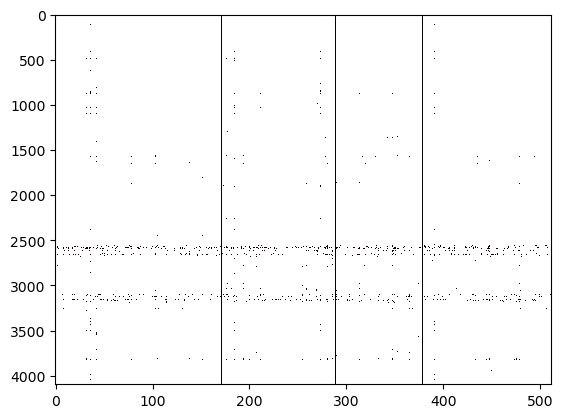

In [58]:
plt.imshow(mask.cpu().numpy(), aspect = "auto", cmap = "hot", interpolation = "nearest")

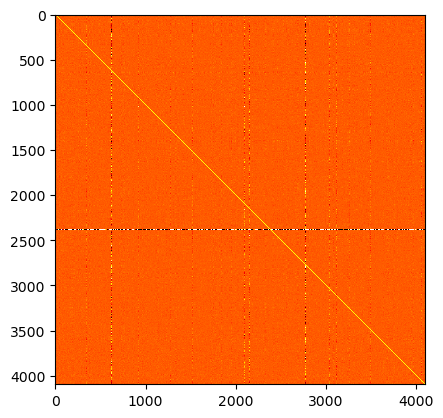

In [121]:
#divide H by its diagonal
H_ = H / torch.diag(H).unsqueeze(1)
H_ = torch.clip(H_, -2, 2)

i1 = 10000
i2 = 1250
cbar = plt.imshow(H_ .numpy(), cmap="hot", interpolation="nearest")
# plt.colorbar(cbar)

In [122]:
np.exp(magnitude_codebook[:,0][magnitude_assignments])

array([0.04895294, 0.02418004, 0.06118634, ..., 0.06118634, 0.06801527,
       0.0755034 ], dtype=float32)

In [123]:
weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]
weights_reconstructued_flat[mask,:] = centriods[assignments,:] * torch.from_numpy(np.exp(magnitude_codebook[:,0][magnitude_assignments])).reshape(-1,1).float()

weights_reconstructued_flat
# weights_reconstructued = torch.zeros_like(weights)

tensor([[[ 4.6173e-04, -4.0985e-03, -1.9066e-02,  ...,  2.4387e-04,
          -2.3356e-03,  1.0368e-03],
         [ 2.4299e-05, -9.3953e-06, -6.1837e-04,  ..., -1.5436e-04,
          -1.4519e-04,  1.5833e-04],
         [ 6.1488e-05, -2.3774e-05, -1.5647e-03,  ..., -3.9059e-04,
          -3.6740e-04,  4.0065e-04],
         ...,
         [-7.4875e-04, -1.1762e-03,  2.3570e-02,  ..., -1.8039e-04,
          -2.2402e-03,  6.2147e-04],
         [-9.1646e-04, -9.3994e-04, -3.9008e-04,  ...,  3.6175e-02,
          -3.3618e-04,  1.9991e-03],
         [-7.7556e-03,  5.9658e-04, -3.7485e-04,  ...,  1.2096e-03,
           2.1439e-03, -3.7496e-02]],

        [[ 3.2830e-04, -7.9099e-03,  3.0733e-04,  ..., -5.0788e-05,
           8.5064e-03, -1.5833e-04],
         [ 5.6174e-05,  7.7114e-05, -2.1853e-04,  ..., -2.5242e-02,
           6.8013e-04, -3.6764e-04],
         [-5.6967e-04, -1.9340e-03, -2.2039e-03,  ..., -3.0491e-04,
          -1.3272e-02,  3.5321e-04],
         ...,
         [-4.0389e-04, -4

In [124]:
weights_reconstructued = torch.empty_like(weights)

weights_reconstructued[:,row_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)

In [125]:
weights_reconstructued


tensor([[ 4.6173e-04, -4.0985e-03, -1.9066e-02,  ...,  1.2096e-03,
          2.1439e-03, -3.7496e-02],
        [ 3.2830e-04, -7.9099e-03,  3.0733e-04,  ..., -9.6113e-05,
          1.6098e-02, -2.9963e-04],
        [-2.0733e-04,  1.7851e-02, -6.9155e-04,  ...,  8.3428e-06,
          7.6175e-04,  4.0319e-05],
        ...,
        [ 1.1142e-04,  1.5295e-04, -4.3344e-04,  ...,  1.6080e-05,
          1.4682e-03,  7.7709e-05],
        [-2.5764e-02,  5.3984e-04, -4.2009e-03,  ..., -2.8995e-04,
         -3.6007e-03,  9.9890e-04],
        [-9.1354e-04, -1.0903e-03,  8.9739e-04,  ..., -9.5208e-04,
         -4.1442e-02,  1.1029e-03]])

In [126]:
weights

tensor([[-0.0096, -0.0301,  0.0085,  ...,  0.0178, -0.0052, -0.0365],
        [-0.0029, -0.0101,  0.0100,  ...,  0.0147,  0.0040, -0.0104],
        [-0.0004,  0.0139, -0.0074,  ..., -0.0083, -0.0070,  0.0146],
        ...,
        [-0.0107, -0.0061,  0.0310,  ..., -0.0052, -0.0143,  0.0236],
        [-0.0104, -0.0213, -0.0129,  ..., -0.0199, -0.0143, -0.0103],
        [ 0.0184,  0.0119,  0.0195,  ...,  0.0343, -0.0327, -0.0355]])

In [127]:
diff = weights - weights_reconstructued

average_error = torch.sum((diff)**2)/torch.sum(weights**2)

H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

print(f"average error {average_error}, H error {H_error}")

average error 0.5367690920829773, H error 297.4764709472656


In [128]:
mask.shape

torch.Size([4096, 512])

In [ ]:
our_cluster(torch.tensor(weights_norms_masked), k_magnitude_codebook, H_diag_use, n_iter = n_iters)

(array([1041277.,       0.,       0., 1018712.,       0.,       0.,
        1056561.,       0.,       0., 1035810.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

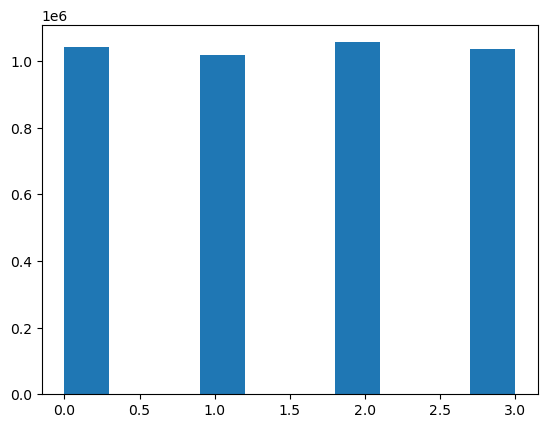

In [135]:
plt.hist(assignments.numpy())